In [1]:
'''
SWIM: Stellar Wind and Irradiance Module

Created on June 6th 2022 @ 3rd Eddy Cross Disciplinary Symposium, Vail, CO, USA.
Code based on original idea by Dan Marsh (NCAR, University of Leeds).

Authors and contributers:

Gregory Cooke (University of Leeds, pygjc@leeds.ac.uk)
Allison Youngblood (NASA Goddard)
Caitlin Gough (University of Leeds)
James Colliander (University of British Columbia)
Fernando Pérez (University of California, Berkeley)
Meng Lin (Lockheed Martin Solar & Astrophysics Lab / SETI Institute)
'''

'''
User Guide

Code to read in files from the MUSCLES database and scale them to be used in 
various atmospheric models for different planets in those stellar systems.
Run each cell until drop down menus appear.
Select your desired options from dropdown menus.
A file with wavelength and flux will be saved out.
This is a .nc (netCDF file) for CAM/WACCM, for example.
'''

'''
To do list (community input required)
- Add in stellar wind models
- Add different climate model wavelength grids (only WACCM, ROCKE-3D, custom grids - and possibly Atmos - so far)
- These wavelength grids are not known to us (we could not find them)
- Add in different ways to save the data (e.g. files such as .csv, .txt etc.) to be compatable with different models
'''

'\nTo do list (community input required)\n- Add in stellar wind models\n- Add different climate model wavelength grids (only WACCM, ROCKE-3D, custom grids - and possibly Atmos - so far)\n- These wavelength grids are not known to us (we could not find them)\n- Add in different ways to save the data (e.g. files such as .csv, .txt etc.) to be compatable with different models\n'

In [2]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from ipywidgets import interactive
import matplotlib.gridspec as gridspec
from astropy.io import fits
import ipywidgets as widgets
import json
import os
from scipy.integrate import trapz

In [3]:
# return subscript number or text as a string
def sub(Input):
    return r'$_{'+str(Input)+'}$'

# return superscript number or text as a string
def sup(Input):
    return r'$^{'+str(Input)+'}$'

In [4]:
#MUSCLES data type selection

#get a drop down menu
Data_Type_List = ['Constant native resolution','Variable native resolution','Constant adaptive resolution','Variable adaptive resolution']

#select data type from MUSCLES files
data_type = widgets.Dropdown(options=(Data_Type_List),description='Data type selection',disabled=False)
display(data_type)

Dropdown(description='Data type selection', options=('Constant native resolution', 'Variable native resolution…

In [5]:
'''
program options begin here
List of MUSCLES database below
'''

#reads in json files for MUSCLES data 

if (data_type.value == 'Constant adaptive resolution'): 
    stellar_names_const_adapt_json = open('stellar_names_const_adapt.json')
    stellar_names_and_data = json.load(stellar_names_const_adapt_json)
elif (data_type.value == 'Constant native resolution'): 
    stellar_names_const_native_json = open('stellar_names_const_native.json')
    stellar_names_and_data= json.load(stellar_names_const_native_json)
elif (data_type.value == 'Variable adaptive resolution'): 
    stellar_names_var_adapt_json = open('stellar_names_var_adapt.json')
    stellar_names_and_data = json.load(stellar_names_var_adapt_json)
elif  (data_type.value == 'Variable native resolution'):
    stellar_names_var_native_json = open('stellar_names_var_native.json')
    stellar_names_and_data = json.load(stellar_names_var_native_json)

#get a drop down menu
#select directories for MUSCLES files
MUSCLES_files = widgets.Dropdown(options=(stellar_names_and_data),description='MUSCLES Files:',disabled=False)
display(MUSCLES_files)

Dropdown(description='MUSCLES Files:', options={'GJ 1132': 'https://archive.stsci.edu/missions/hlsp/muscles/gj…

In [6]:
'''
set Spectra_name_same_as_host_name = False if looking at exoplanets around
a different star to the ones in the MUSCLES database
i.e you want spectra for an M8 star but the closest spectra availiable is TRAPPIST-1
otherwise in this example you will only be able to select TRAPPIST-1 planets 
if Spectra_name_same_as_host_name = True
'''
Spectra_name_same_as_host_name = True
#get star name
star_name = [k for k, v in stellar_names_and_data.items() if v == MUSCLES_files.value][0]

In [7]:
# Import MUSCLES spectra
if(os.path.isfile(MUSCLES_files.value)): print('File already downloaded')
else:os.system('wget '+ MUSCLES_files.value)

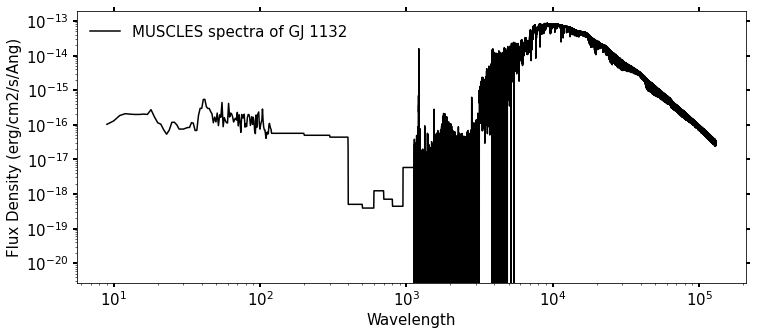

In [8]:
spec = fits.getdata(MUSCLES_files.value,1)
plt.figure(figsize = (12,5))
plt.plot(spec['WAVELENGTH'],spec['FLUX'], color = 'k', label = 'MUSCLES spectra of '+star_name)
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density (erg/cm2/s/Ang)', fontsize = 15); plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)

In [9]:
#convert to mW/m2/nm
per_cm2_to_per_m2 = 100**2
erg_per_s_to_mW = 1e-4
per_Ang_to_per_nm = 10
New_flux = spec['FLUX'] * erg_per_s_to_mW * per_cm2_to_per_m2 * per_Ang_to_per_nm
# may need to change for different models
Wavelength = spec['WAVELENGTH']/10
plot_Wavelength = spec['WAVELENGTH']/10

In [10]:
#remove MUSCLES files in current directory
os.system('rm *muscles*.fits')

0

In [11]:
#Select climate model
#Other clime models can be included
#Please email Greg Cooke at pygjc@leeds.ac.uk
Climate_model_list = ['WACCM', 'CAM', 'ExoCam', 'UM', 'LMD-G', 'ROCKE-3D', 'CCSM3', 'Atmos', 'Custom constant grid', 'Custom variable grid']
Climate_model_selection = widgets.Dropdown(options=Climate_model_list,description='Select climate model',disabled=False)
display(Climate_model_selection)

Dropdown(description='Select climate model', options=('WACCM', 'CAM', 'ExoCam', 'UM', 'LMD-G', 'ROCKE-3D', 'CC…

In [12]:
#Compare to WACCM standard solar file

#Some standard initilisations outside of if/elif statements
Irradiance_at_Earth = 1360000
xlim = (10,1e5) #xlim for plots

#certain exoplanet/climate models require different files types
if (Climate_model_selection.value == 'WACCM' or Climate_model_selection.value == 'CAM'):
    #check for file. Download if not in directory
    if(os.path.isfile('SolarForcingCMIP6piControl_c160921.nc')): print('File already downloaded')
    else: os.system('wget https://svn-ccsm-inputdata.cgd.ucar.edu/trunk/inputdata/atm/cam/solar/SolarForcingCMIP6piControl_c160921.nc --no-check-certificate')
    solar_file = 'SolarForcingCMIP6piControl_c160921.nc'#read in file

    ds = xr.open_dataset(solar_file)#attach file to dataset
    ssi = ds['ssi'].isel(time=0) #define dataset from file
    model_flux = ssi.values #flux values
    model_wavelength = ssi.wavelength.values #wavelength grid
    starlabel = 'Sun' #label for plot
    Irradiance_at_Earth = 1360000
    xlim = (10,1e5)#xlim for plots
    
elif(Climate_model_selection.value == 'ExoCAM'):
    print('ExoCam spectrum input file unknown')  
    
elif(Climate_model_selection.value == 'UM'):
    print('UM spectrum input file unknown')  
    
elif(Climate_model_selection.value == 'LMD-G'):
    print('LMD-G spectrum input file unknown')  
    
elif(Climate_model_selection.value == 'ROCKE-3D'):
    #check for file. Download if not in directory
    if(os.path.isfile('sun')): print('File already downloaded')
    else: os.system('wget https://portal.nccs.nasa.gov/GISS_modelE/ROCKE-3D/stellar_spectra/sun')
    solar_file = 'SolarForcingCMIP6piControl_c160921.nc'#read in file
    ROCKE_3D_solar_input = np.genfromtxt('sun', skip_header = 5, skip_footer = 1)
    model_flux = ROCKE_3D_solar_input[:,1]
    model_wavelength =  ROCKE_3D_solar_input[:,0]*1e9 #wavelength grid
    starlabel = 'Sun' #label for plot
    Irradiance_at_Earth = 1360 #in units of Wm^-2
    Wavelength = Wavelength*1e-9 #convert to m
    xlim = (100,1e5)#xlim for plots
    
elif(Climate_model_selection.value == 'CCSM3'):
    print('CCSM3 spectrum input file unknown') 
    
elif(Climate_model_selection.value == 'Atmos'):
    if(os.path.isfile('muscles_gj667c.txt')): print('File already downloaded')
    else: os.system('wget https://raw.githubusercontent.com/VirtualPlanetaryLaboratory/atmos/master/PHOTOCHEM/DATA/FLUX/muscles_gj667c.txt')
    ATMOS_gj667c_input = np.genfromtxt('muscles_gj667c.txt')
    model_wavelength = ATMOS_gj667c_input[:,0]/10
    model_flux = ATMOS_gj667c_input[:,1]
    starlabel = 'GJ 667 C'
    
    
elif(Climate_model_selection.value == 'Custom constant grid'):
    print('Please enter starting wavelength in nm')
    a = float(input())
    print('Please enter final wavelength in nm')
    b = float(input())
    print('Please enter wavelength binning in nm')
    c = float(input())
    model_wavelength = np.arange(a,b+c,c)
    
elif(Climate_model_selection.value == 'Custom variable grid'):
    print('NOTE THAT: the current functionality is to read in a text file of wavelength vs flux\nusing np.genfromtxt(filename).')
    print('Please enter the file name of the custom wavelength grid')
    #get file name
    file_name = input()
    #get wavelength multiplier
    print('Please enter the multiplier for the wavelength in order to convert to nm')
    multiplier = float(input())
    
    Input_file = np.genfromtxt(file_name)
    model_wavelength = Input_file[:,0]*multiplier
    model_flux = Input_file[:,1]
    
    #Should it just be .txt files or other types too?
    
else:
    print('Spectrum input file unknown')

File already downloaded


Total stellar irradiance from original file relative to the Sun: 6.949089685274155e-16
Scaled total stellar irradiance relative to the Sun: 1.0000000000000004


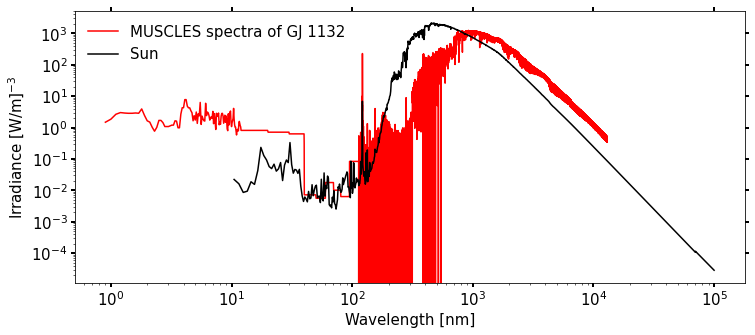

In [13]:
#find total stellar irradiance from file
#get total stellar irradiance at top of atmosphere

TSI_spectra = trapz(New_flux, Wavelength)
print('Total stellar irradiance from original file relative to the Sun: '+ str(TSI_spectra/Irradiance_at_Earth))

# scale TSI
Scaled_flux_to_Earth = New_flux/(TSI_spectra/Irradiance_at_Earth)
TSI_spectra = trapz(Scaled_flux_to_Earth, Wavelength)
print('Scaled total stellar irradiance relative to the Sun: '+ str(TSI_spectra/Irradiance_at_Earth))

#compare spectra to Sun
plt.figure(figsize = (12,5))
plt.plot(plot_Wavelength, Scaled_flux_to_Earth, color = 'r', label = 'MUSCLES spectra of '+star_name)
plt.plot(model_wavelength, model_flux, color = 'k', label = starlabel)
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
plt.ylabel('Irradiance [W/m]'+sup(-3), fontsize = 15); plt.yscale('log')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)

In [14]:
#read in only the following rows from the NASA exoplanet archive:
#pl_name,hostname,st_lum,pl_orbsmax,st_teff,rowupdate
NASA_Exo_Archive = pd.read_csv('https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+pl_name,hostname,st_lum,pl_orbsmax,st_teff,rowupdate+from+ps&format=csv')

In [15]:
#Find planets based on host name
if (Spectra_name_same_as_host_name == True):
    #choose planet
    planets = NASA_Exo_Archive.loc[NASA_Exo_Archive['hostname'] == star_name]['pl_name']
    Find_planets = widgets.Dropdown(options=planets.drop_duplicates(),description='Find planets',disabled=False)
    display(Find_planets)
else:
    Find_host = widgets.Dropdown(options=(NASA_Exo_Archive['hostname'].drop_duplicates()),description='Find host',disabled=False)
    display(Find_host)
    
    #choose planet
    planets = NASA_Exo_Archive.loc[NASA_Exo_Archive['hostname'] == Find_host.value]['pl_name']
    Find_planets = widgets.Dropdown(options=planets,description='Find planets',disabled=False)
    display(Find_planets)

Dropdown(description='Find planets', options=('GJ 1132 b', 'GJ 1132 c'), value='GJ 1132 b')

In [22]:
#drop nan rows for luminosity and orbital period
# pl = NASA_Exo_Archive.loc[NASA_Exo_Archive['pl_name'] == Find_planets.value].dropna(subset='st_lum')
# pl = pl.dropna(subset='pl_orbsmax')
pl = NASA_Exo_Archive.loc[NASA_Exo_Archive['pl_name'] == Find_planets.value].dropna(subset=['st_lum','pl_orbsmax'])

#find semi-major axis in AU
pl = pl.sort_values(by=['rowupdate'])
semi_major_axis = pl['pl_orbsmax'].iloc[-1]
print('semi-major axis of '+Find_planets.value+' = '+str(semi_major_axis)+' AU')

#find solar luminosity relative to Sun
stellar_luminosity = 10**pl['st_lum'].iloc[-1]
print('Star has '+str(stellar_luminosity)+ ' times luminosity of Sun')

#find the flux recieved relative to Earth
flux_recieved_relative_to_Earth = stellar_luminosity/(semi_major_axis**2)
print(Find_planets.value+' recieves '+str(flux_recieved_relative_to_Earth)+ ' times flux recieved by Earth')

semi-major axis of GJ 1132 b = 0.0153 AU
Star has 0.004375221051582521 times luminosity of Sun
GJ 1132 b recieves 18.690337270205994 times flux recieved by Earth


In [17]:
#download spectres
!pip install spectres
#import spectres 
import spectres as sp

#get maximum and minimum wavelength regions
min_wav = np.argmin(abs(Wavelength-model_wavelength[0]))
max_wav = np.argmin(abs(plot_Wavelength[-1]-model_wavelength))

TSI_spectra_muscles = trapz(Scaled_flux_to_Earth[min_wav:], Wavelength[min_wav:])
if (Climate_model_selection.value == 'WACCM'):
    print('Total stellar irradiance from Muscles spectra is: ' + str(round(TSI_spectra_muscles,2))+ ' W/m^2/nm')
elif (Climate_model_selection.value == 'ROCKE-3D'):
    print('Total stellar irradiance from Muscles spectra is: ' + str(TSI_spectra_muscles)+ ' W/m^3')
new_wav_grid = model_wavelength[:max_wav]
New_grid_flux = sp.spectres(new_wav_grid, plot_Wavelength, Scaled_flux_to_Earth, spec_errs=None)
TSI_spectra_model = trapz(New_grid_flux, new_wav_grid)

if (Climate_model_selection.value == 'WACCM'):
    print('Total stellar irradiance from ' + starlabel + ' spectra is: ' + str(round(TSI_spectra_model,2))+ ' W/m^2/nm')
elif (Climate_model_selection.value == 'ROCKE-3D'):
    print('Total stellar irradiance from ' + starlabel + ' spectra is: ' + str(TSI_spectra_model)+ ' W/m^3')

print('Ratio of MUSCLES spectra to  ' + starlabel + ' spectra is: ' + str(round(TSI_spectra_muscles/TSI_spectra_model,6)))

# rescale to planet based on stellar luminoisty and semi-major axis from the NASA exoplanet archive
Initial_scaled_flux = New_grid_flux * flux_recieved_relative_to_Earth
TSI_spectra = trapz(Initial_scaled_flux, new_wav_grid)
print('Scaled total stellar irradiance relative to the Sun: '+ str(TSI_spectra/Irradiance_at_Earth))

Total stellar irradiance from Muscles spectra is: 1359977.32 W/m^2/nm
Total stellar irradiance from Sun spectra is: 1359943.29 W/m^2/nm
Ratio of MUSCLES spectra to  Sun spectra is: 1.000025
Scaled total stellar irradiance relative to the Sun: 18.689557958126517


(10, 100000.0)

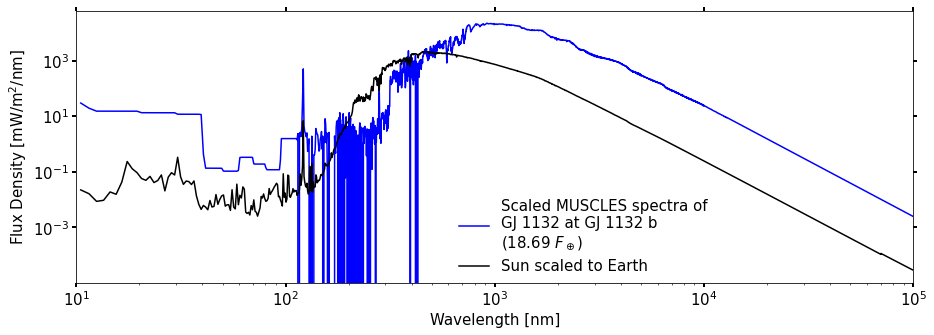

In [18]:
#Extend spectra using Raleigh Jeans Law
#add in functionality with PHOENIX for later
k = 1.381e-23
c = 299792458
T = pl['st_teff'].iloc[-1]
scaling = Initial_scaled_flux[max_wav-1]
RJL = 2*c*k*T/((model_wavelength[max_wav]*1e-9)**4)

IR_scaling = scaling/RJL
RJL_scaling = (IR_scaling)*(2*c*k*T/((model_wavelength*1e-9)**4))

Flux = np.append(Initial_scaled_flux, RJL_scaling[max_wav:])

RJL = 2*c*k*T/((new_wav_grid[-1]*1e-9)**4)

plt.figure(figsize = (15,5))
plt.plot(model_wavelength, Flux, color = 'b', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(flux_recieved_relative_to_Earth,3))+' '+r'$F_\oplus$'+')')
plt.plot(model_wavelength,model_flux, color = 'k', label = starlabel+' scaled to Earth')
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density [mW/m'+sup(2)+'/nm]', fontsize = 15); plt.yscale('log')
plt.legend(loc = (0.45,0.01), frameon = False, fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.xlim(xlim)

In [19]:
#after adding in IR through Rayleigh Jeans law, provide final scaling 
#this should not be a large factor (<1% difference) if model includes wavelengths up to 10,000 nm
#however, note that it would be more realistic to use the PHOENIX code for this extension

final_scaling = flux_recieved_relative_to_Earth/(trapz(Flux, model_wavelength) / Irradiance_at_Earth)
if(Climate_model_selection.value == 'ROCKE-3D'):
    final_scaling = flux_recieved_relative_to_Earth/(trapz(Flux, model_wavelength*1e-9) / Irradiance_at_Earth)

Final_scaled_flux = final_scaling*Flux

In [20]:
#now write out the files to the working directory
if (Climate_model_selection.value == 'WACCM' or Climate_model_selection.value == 'CAM'):
    ds.ssi.values[0] = Final_scaled_flux; ds.ssi.values[1] = Final_scaled_flux
    NewFile = 'TOA_Flux_at_'+Find_planets.value+'_for_'+Climate_model_selection.value+'.nc'
    NewFile = NewFile.replace(" ", "_")
    ds.to_netcdf(NewFile)
    print('File saved')
elif (Climate_model_selection.value == 'ROCKE-3D'):
    NewFile = 'TOA_Flux_at_'+Find_planets.value+'_for_'+Climate_model_selection.value
    NewFile = NewFile.replace(" ", "_")
    df = pd.DataFrame(data={'Wavelength [m]': model_wavelength, 'Flux [W/m^3]':  Final_scaled_flux})
    df.to_csv(NewFile+'.txt', index = False)
    print('File saved')
elif (Climate_model_selection.value == 'Atmos'):
    NewFile = 'TOA_Flux_at_'+Find_planets.value+'_for_'+Climate_model_selection.value
    NewFile = NewFile.replace(" ", "_")
    df = pd.DataFrame(data={'Wavelength [m]': model_wavelength, 'Flux [W/m^3]':  Final_scaled_flux})
    df.to_csv(NewFile+'.txt', index = False)
    print('File saved')
else:
    print('File not saved')

File saved


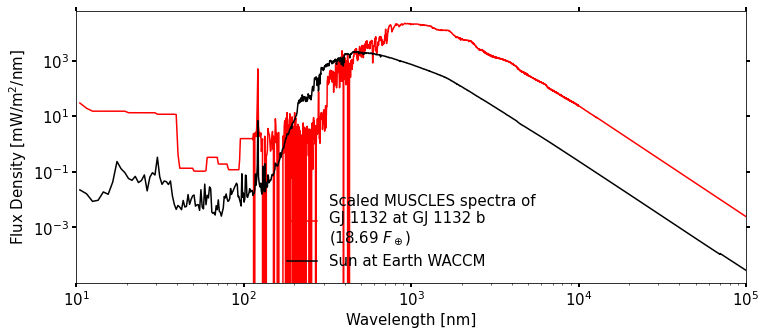

In [21]:
#plot rebinned spectra compared to Sun
if (Climate_model_selection.value == 'WACCM'):
    plt.figure(figsize = (12,5))
    plt.plot(model_wavelength, Final_scaled_flux, color = 'r', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(TSI_spectra/Irradiance_at_Earth,3))+' '+r'$F_\oplus$'+')')
    plt.plot(model_wavelength,model_flux, color = 'k', label = starlabel+' at Earth '+Climate_model_selection.value)
    plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
    plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
    plt.ylabel('Flux Density [mW/m'+sup(2)+'/nm]', fontsize = 15); plt.yscale('log')
    plt.legend(loc = 0, frameon = False, fontsize = 15)
    plt.xlim(10,1e5)

elif(Climate_model_selection.value == 'ROCKE-3D'):
    plt.figure(figsize = (12,5))
    plt.plot(model_wavelength, Final_scaled_flux, color = 'r', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(flux_recieved_relative_to_Earth,3))+' '+r'$F_\oplus$'+')')
    plt.plot(model_wavelength,model_flux, color = 'k', label = starlabel+' at Earth ROCKE-3D '+Climate_model_selection.value)
    plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
    plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
    plt.ylabel('Flux Density [W/m'+sup(3)+']', fontsize = 15); plt.yscale('log')
    plt.legend(loc = 0, frameon = False, fontsize = 15)
    plt.xlim(100,1e5)
    
else:
    print('rebinning not yet implemented for '+Climate_model_selection.value)
    